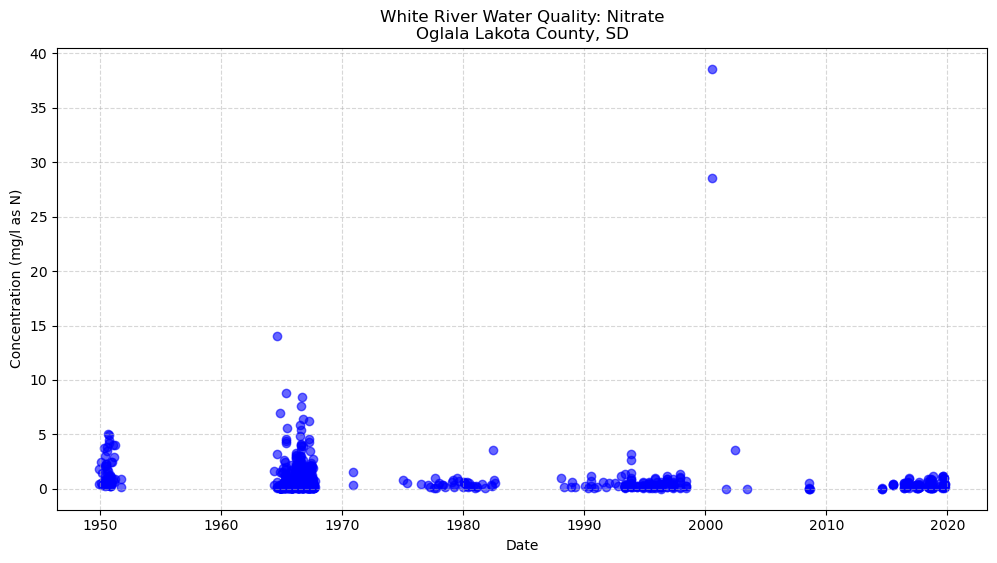

Success! Data saved to 'white_river_water_quality.csv'


In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

# Define the parameters
params = {
    "countrycode": "US",
    "statecode": "US:46",
    "countycode": "US:46:102",
    "siteType": "Stream",
    "characteristicName": "Nitrate",
    "startDate": "2020-01-01",
    "endDate": "2023-12-31",
    "mimeType": "csv",  # Using CSV instead of JSON for more reliable parsing
}

# USGS Water Quality Portal API endpoint
url = "https://www.waterqualitydata.us/data/Result/search"

try:
    # Fetch data
    response = requests.get(url, params=params, timeout=30)
    response.raise_for_status()  # Raises an exception for 4XX/5XX errors
    
    # Check if response is empty
    if not response.content:
        raise ValueError("Empty response from server")
    
    # Try parsing as CSV
    df = pd.read_csv(StringIO(response.text))
    
    if not df.empty:
        # Clean and extract relevant columns
        columns_to_keep = [
            "MonitoringLocationIdentifier",
            "ActivityStartDate",
            "CharacteristicName",
            "ResultMeasureValue",
            "ResultMeasure/MeasureUnitCode"
        ]
        
        # Ensure columns exist
        available_columns = [col for col in columns_to_keep if col in df.columns]
        if not available_columns:
            raise ValueError("No expected columns found in response")
            
        df = df[available_columns].dropna()
        
        # Convert dates and numeric values
        df["ActivityStartDate"] = pd.to_datetime(df["ActivityStartDate"])
        df["ResultMeasureValue"] = pd.to_numeric(df["ResultMeasureValue"], errors="coerce")
        
        # Plot time-series
        plt.figure(figsize=(12, 6))
        plt.scatter(df["ActivityStartDate"], df["ResultMeasureValue"], color="blue", alpha=0.6)
        plt.title(f"White River Water Quality: {df['CharacteristicName'].iloc[0]}\nOglala Lakota County, SD")
        plt.xlabel("Date")
        plt.ylabel(f"Concentration ({df['ResultMeasure/MeasureUnitCode'].iloc[0]})")
        plt.grid(True, linestyle="--", alpha=0.5)
        plt.show()
        
        # Save to CSV
        df.to_csv("white_river_water_quality.csv", index=False)
        print(f"Success! Data saved to 'white_river_water_quality.csv'")
    else:
        print("No water quality data found for the specified parameters.")

except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")
except pd.errors.EmptyDataError:
    print("Received empty data from the API")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

In [3]:
import pandas as pd

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('white_river_water_quality.csv')

# Display the first few rows to verify
print(df.head())

# Display basic information about the DataFrame
print(df.info())

# Display summary statistics for numerical columns
print(df.describe())

  MonitoringLocationIdentifier ActivityStartDate CharacteristicName  \
0                USGS-06446000        1950-04-11            Nitrate   
1                USGS-06446000        1950-04-11            Nitrate   
2                USGS-06446000        1950-08-15            Nitrate   
3                USGS-06446000        1950-08-15            Nitrate   
4                USGS-06446000        1950-07-17            Nitrate   

   ResultMeasureValue ResultMeasure/MeasureUnitCode  
0               0.836                     mg/l as N  
1               3.700                    mg/l asNO3  
2               0.361                     mg/l as N  
3               1.600                    mg/l asNO3  
4               0.316                     mg/l as N  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   MonitoringLocationId

In [4]:


# Read the CSV file
df = pd.read_csv('white_river_water_quality.csv')

# Extract only the date and nitrate columns
nitrate_data = df[['ActivityStartDate', 'ResultMeasureValue']].copy()

# Rename columns for clarity
nitrate_data.columns = ['Date', 'Nitrate_Level']

# Convert Date to datetime format
nitrate_data['Date'] = pd.to_datetime(nitrate_data['Date'])

# Remove any rows with missing values
nitrate_data = nitrate_data.dropna()

# Display the cleaned data
print(nitrate_data.head())

# Optional: Save to new CSV
nitrate_data.to_csv('white_river_nitrate_levels.csv', index=False)

        Date  Nitrate_Level
0 1950-04-11          0.836
1 1950-04-11          3.700
2 1950-08-15          0.361
3 1950-08-15          1.600
4 1950-07-17          0.316


In [8]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Read your water quality CSV
water_quality = pd.read_csv("white_river_water_quality.csv")

# Get unique station IDs from your data
station_ids = water_quality["MonitoringLocationIdentifier"].unique()
print(f"Found {len(station_ids)} monitoring stations")

# Fetch station locations from USGS
stations_url = "https://www.waterqualitydata.us/data/Station/search"
params = {
    "siteid": ",".join(station_ids),
    "mimeType": "csv"
}

response = requests.get(stations_url, params=params)
stations = pd.read_csv(StringIO(response.text))

# Convert to GeoDataFrame
gdf_stations = gpd.GeoDataFrame(
    stations,
    geometry=gpd.points_from_xy(stations.LongitudeMeasure, stations.LatitudeMeasure),
    crs="EPSG:4326"  # WGS84
)

Found 37 monitoring stations
